# **RAFT DIVE**

In this notebook we will dive into RAFT, explore how it works, and gain intuition that will allow us to use it with other Advanced Neural Networks.

In [1]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# add RAFT to core path
sys.path.append('RAFT/core')
     
from raft_utils import *

## **Run RAFT on test images**

In [3]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread(os.path.join(demo_path, 'frame_0020.png'))
# frame2 = cv2.imread(os.path.join(demo_path, 'frame_0021.png'))
frame2 = cv2.imread(os.path.join(demo_path, 'frame_0023.png')) # large displacement

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

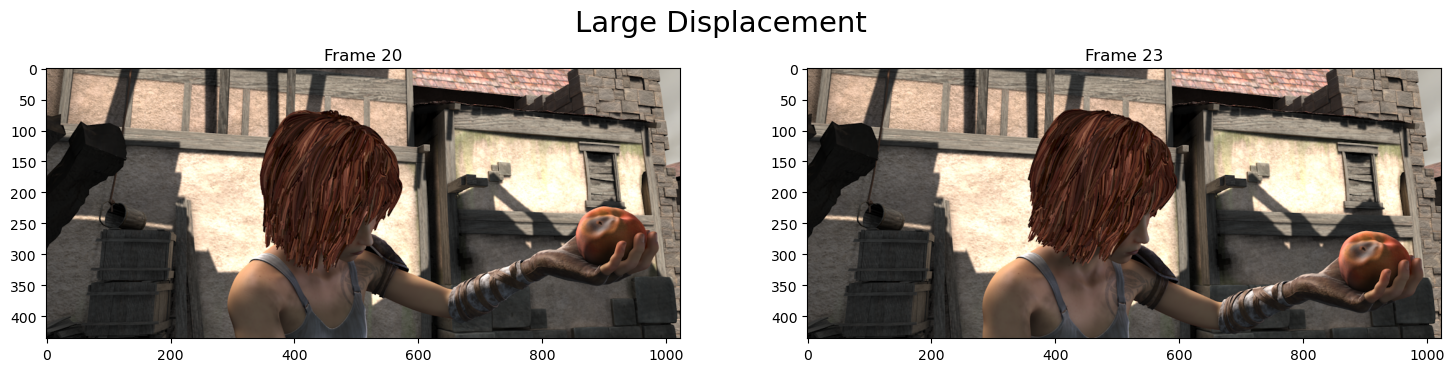

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
fig.suptitle("Large Displacement", size=21)
ax[0].imshow(frame1)
ax[0].set_title("Frame 20")
ax[1].imshow(frame2)
ax[1].set_title("Frame 23");

In [5]:
frame1.shape

(436, 1024, 3)

In [6]:
# load model
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

# predict Optical Flow
flow_iters = inference(model, frame1, frame2, device='cuda', iters=20, test_mode=False)

c:\Users\itber\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


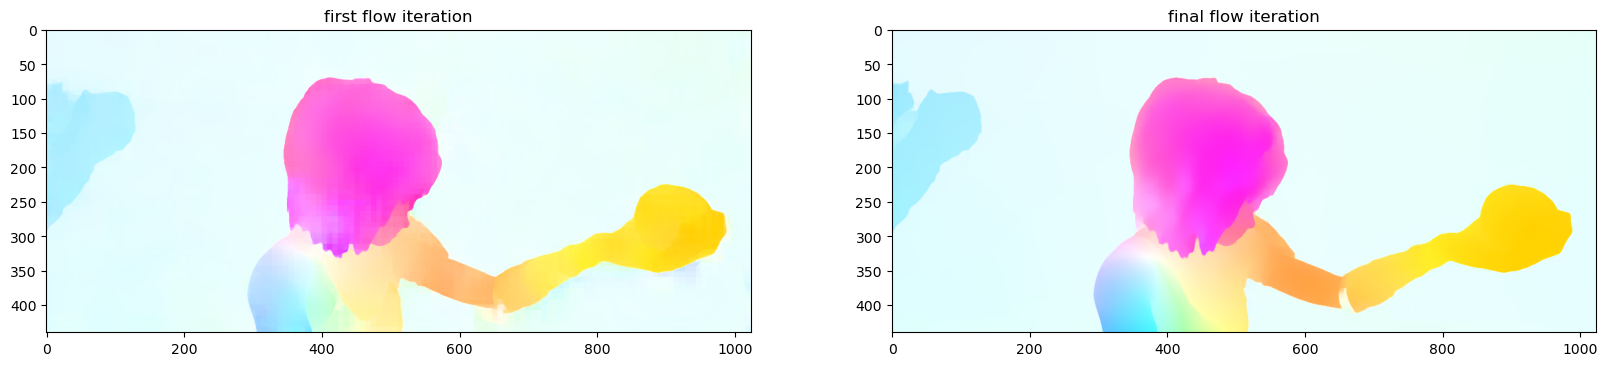

In [7]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_iters[0]))
ax0.set_title('first flow iteration')
ax1.imshow(get_viz(flow_iters[-1]))
ax1.set_title('final flow iteration');

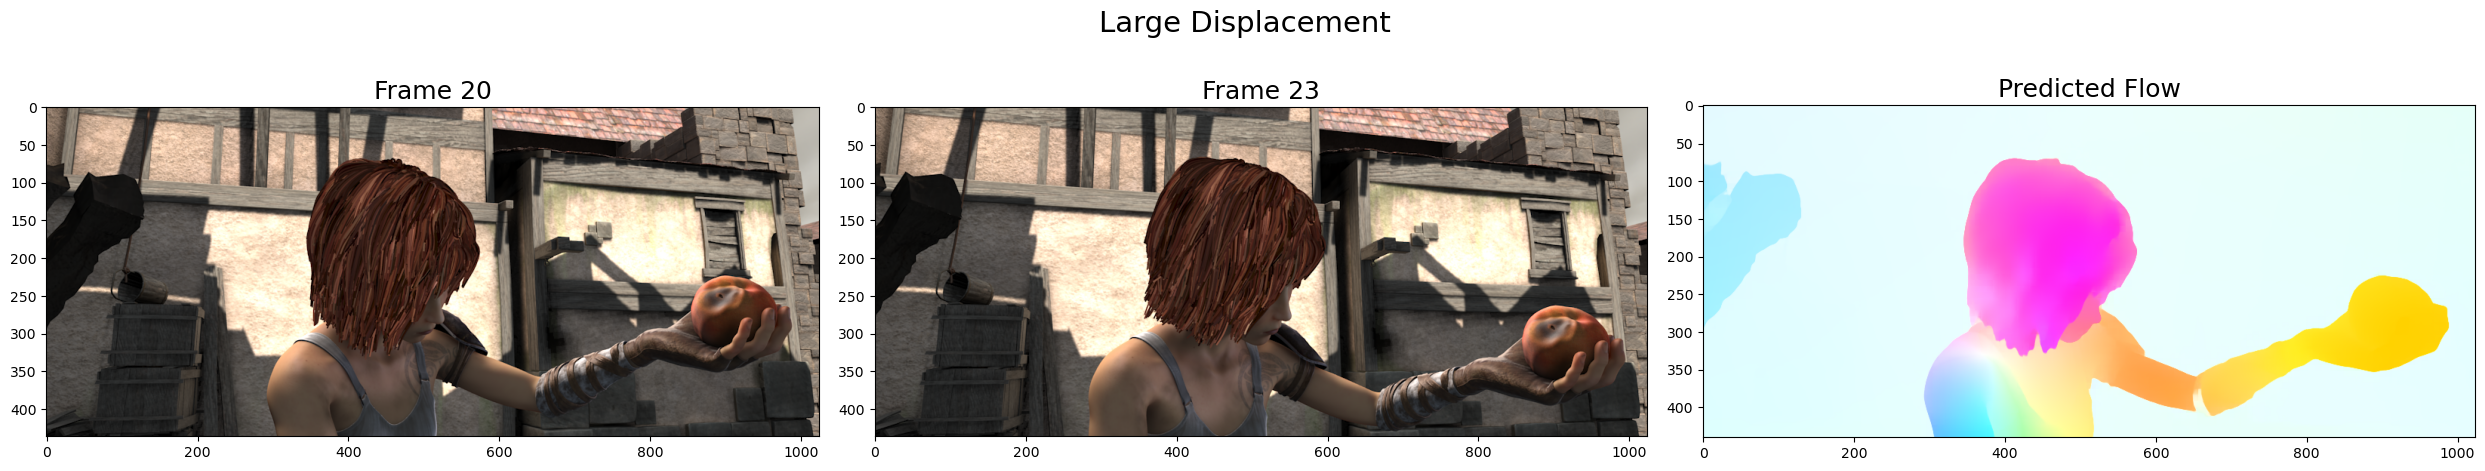

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
fig.suptitle("Large Displacement", size=21)
ax[0].imshow(frame1)
ax[0].set_title("Frame 20", size=18)
ax[1].imshow(frame2)
ax[1].set_title("Frame 23", size=18)
ax[2].imshow(get_viz(flow_iters[-1]))
ax[2].set_title("Predicted Flow", size=18);

fig.tight_layout();

Get test pixels places of high, low, and medium flow

In [9]:
flow = flow_iters[-1].squeeze(0).cpu().numpy()
abs_flow = np.abs(flow)

# highest abs flow in each direction
hi_flow_1 = np.where(abs_flow == abs_flow[0, :, :].max()) # u - horizontal
hi_flow_2 = np.where(abs_flow == abs_flow[1, :, :].max()) # v - vertical

# lowest abs flow in each direction
lo_flow_1 = np.where(abs_flow == abs_flow[0, :, :].min()) # u - horizontal
lo_flow_2 = np.where(abs_flow == abs_flow[1, :, :].min()) # v - vertical

# mean abs flow in each direction
me_flow_1 = np.where((abs_flow <= abs_flow[0, :, :].mean() + 1e-4)
                     & (abs_flow >= abs_flow[0, :, :].mean() - 1e-4)) 
me_flow_2 = np.where((abs_flow <= abs_flow[1, :, :].mean() + 1e-4)
                     & (abs_flow >= abs_flow[1, :, :].mean() - 1e-4)) 


lo_flow_1 = np.dstack(lo_flow_1).squeeze()
lo_flow_2 = np.dstack(lo_flow_2).squeeze()

hi_flow_1 = np.dstack(hi_flow_1).squeeze()
hi_flow_2 = np.dstack(hi_flow_2).squeeze()

# me_flow_1 = np.dstack(me_flow_1).squeeze()[0]
# me_flow_2 = np.dstack(me_flow_2).squeeze()[0]

## **RUN Test inference of RAFT**

### Get Test pixel

NOTE: For the test pixel we only consider the most extreme horizontal or the most extreme vertical pixel displacements

In [10]:
frame1.shape

(436, 1024, 3)

In [11]:
# get test pixel
pix = 1
# flow_locs = [lo_flow_1, lo_flow_2, hi_flow_1, hi_flow_2]
flow_locs = [lo_flow_1, lo_flow_2, hi_flow_2]

test_pixel = flow_locs[pix]

flow_at_tp = flow_iters[-1].cpu().squeeze(0)[:, test_pixel[1], test_pixel[2]]

print(f"test pixel: {test_pixel} - flow at test pixel: {flow_at_tp}")

test pixel: [  1 159  95] - flow at test pixel: tensor([-1.5071e+01, -8.6781e-06])


#### NOTES

##### **Regular Displacement**
 - lo_flow_1 - horizotnal displacement captured by first pyramid level
 - lo_flow_2 - vertical displacement captured by first pyrmid level
 - hi_flow_1 
 - hi_flow_2 - diagonal displacement 


##### **Large Displacement**
 - lo_flow_1 - (1.5306e-04, 3.8904e+01) @ (304, 791) large positive vertical displacement (correlation captured in level 0, but radius is too small)
 - lo_flow_2 - (-1.4967e+01,  1.3452e-05) @ (156, 102) large negative horizontal displacement 
 - hi_flow_1 -  (34.0357, -18.9150) @ (248, 498) seems to be captured by the 3rd level, amybe the first level as well?
 - hi_flow_2 - (4.7941, 44.7952) @ (329, 952) strongly captured by second level

In [12]:
# predict Optical Flow
model_outputs = test_inference(model, frame1, frame2, device='cuda', iters=20, test_pixel=test_pixel, test_mode=True)
features, test_responses, motion_features, hidden_states, flow_low, flow_up = model_outputs

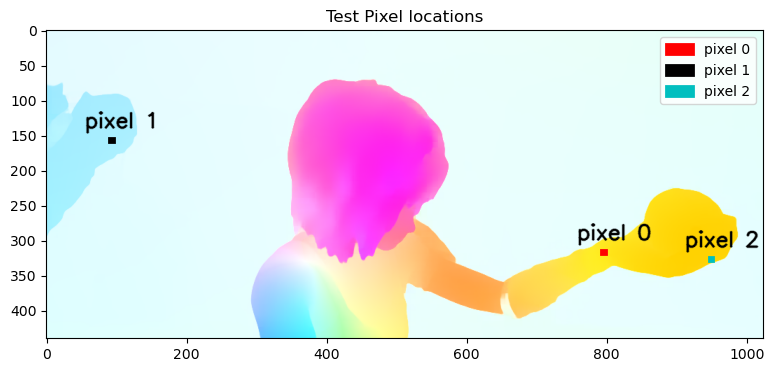

In [13]:
import matplotlib.patches as patches

flow_viz = get_viz(flow_up)


_, ax = plt.subplots(1, 1, figsize=(10, 4))


colors = ['r', 'k', 'c']
for i, (c, loc) in enumerate(zip(colors, flow_locs)):
    rect = patches.Rectangle(loc[1:][::-1] - 5.5, 6, 6, linewidth=2, edgecolor=c, facecolor=c, label=f"pixel {i}")
    ax.add_patch(rect)

    flow_viz = cv2.putText(flow_viz, f"pixel {i}", loc[1:][::-1] - np.array([40, 20]), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)

    # get flow at test pixel
    flow = flow_iters[-1].cpu().squeeze(0)[:, loc[1], loc[2]]



ax.imshow(flow_viz)

ax.set_title("Test Pixel locations");
ax.legend()

## **Inspect Feature Maps**

In [14]:
fmap1, fmap2, hiddn, cntxt = features

fmap1 = fmap1.squeeze(0).cpu().numpy()
fmap2 = fmap2.squeeze(0).cpu().numpy()
hiddn = hiddn.squeeze(0).cpu().numpy()
cntxt = cntxt.squeeze(0).cpu().numpy()

In [15]:
fmap1.shape, fmap2.shape, hiddn.shape, cntxt.shape

((256, 55, 128), (256, 55, 128), (128, 55, 128), (128, 55, 128))

In [ ]:
# idx = 100

# for i in range(128):
#     fig, ax = plt.subplots(2, 2, figsize=(12, 6))

#     fig.suptitle(f"Extracted Feature Maps - {i}")
#     ax[0][0].imshow(fmap1[i, :, :])
#     ax[0][0].set_title("fmap 1")

#     ax[0][1].imshow(fmap2[i, :, :])
#     ax[0][1].set_title("fmap 2")

#     ax[1][0].imshow(hiddn[i, :, :])
#     ax[1][0].set_title("Hidden")

#     ax[1][1].imshow(cntxt[i, :, :])
#     ax[1][1].set_title("Context");

#     fig.savefig(f"C:\\Users\\itber\\Documents\\utils\\gif_maker\\frames_5\\feature_{i}.png")
#     plt.close();

## **Print relative pixel motion at each pyramid level**

In [17]:
for i in range(4):
    # print(test_responses[0][i][2], test_responses[9][i][2], test_responses[0][i][2] - test_responses[9][i][2])
    print(f"Pixel Motion at level: {i}: {test_responses[0][i][2] - test_responses[9][i][2]}")

Pixel Motion at level: 0: [ 1.8775482  -0.00740814]
Pixel Motion at level: 1: [ 0.26170778 -0.02169609]
Pixel Motion at level: 2: [ 0.14692467 -0.00804377]
Pixel Motion at level: 3: [ 0.07308337 -0.00306034]


The pyramid level that captures most of the correspondence information is the level that captures the most displacement. Multiplying the pixel motion at level 0 gives us an approximate flow estimate. Since the current flow estimate is used to find the correspodences in the correlation volumes.

In [18]:
itr = 9 # iterations
pyramid_flow = 8*(test_responses[0][0][2] - test_responses[itr][0][2])
pyramid_flow = 8*2*(test_responses[0][1][2] - test_responses[itr][1][2])

print(f"predicted: {flow_at_tp} - flow at pyramid level 0: {pyramid_flow}")

predicted: tensor([-1.5071e+01, -8.6781e-06]) - flow at pyramid level 0: [ 4.1873245  -0.34713745]


## **Inspect Test Responses**

In [19]:
itr = 0
lvl = 0

### Display correlation response at Test Pixel

In [20]:
# get pixel location
pixel_loc = test_responses[itr][lvl][2]
pixel_loc

array([12., 20.], dtype=float32)

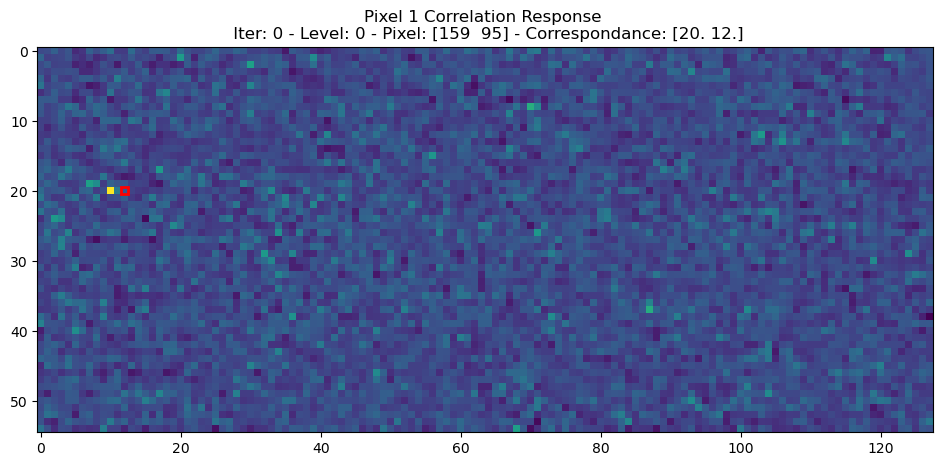

In [21]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.imshow(test_responses[itr][lvl][0]);
ax.set_title(f"Pixel {pix} Correlation Response \n "
             + f"Iter: {itr} - Level: {lvl} - Pixel: {test_pixel[1:]} - Correspondance: {pixel_loc.round(2)[::-1]}");

# mark I2 pixel under test
rect = patches.Rectangle(pixel_loc - 0.5, 1, 1, linewidth=2, edgecolor='r', facecolor='none')
# rect = patches.Rectangle(pixel_loc - (0.5/(2**lvl)), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

# TEMP: draw arrow for display
# plt.arrow(pixel_loc.astype(int)[0] + 3, pixel_loc.astype(int)[1] + 2, -4, 0, linewidth=2, head_width=1, edgecolor='r', facecolor='r') # p0
# plt.arrow(pixel_loc.astype(int)[0] - 2, pixel_loc.astype(int)[1] - 3, 0, 3, linewidth=2, head_width=1, edgecolor='r', facecolor='r') # p1
# plt.arrow(pixel_loc.astype(int)[0] - 3, pixel_loc.astype(int)[1] - 0, 0, 3, linewidth=2, head_width=1, edgecolor='r', facecolor='r') # p2


plt.show();
# fig.savefig(f"C:\\Users\\itber\\Documents\\utils\\gif_maker\\frames_1\\pixel2_iter{itr}");

## Get Zoomed pixel location and Resampled Grid

In [22]:
r = 4
u = slice(int(pixel_loc[0] - r), int(pixel_loc[0] + r + 1)) # horizontal
v = slice(int(pixel_loc[1] - r), int(pixel_loc[1] + r + 1)) # vertical

u = slice(int(np.clip(pixel_loc[0] - r, 0, np.infty)), int(np.clip(pixel_loc[0] + r + 1, 0, np.infty)))
v = slice(int(np.clip(pixel_loc[1] - r, 0, np.infty)), int(np.clip(pixel_loc[1] + r + 1, 0, np.infty)))

zoomed_response = test_responses[itr][lvl][0][v, u]
bilres_response = test_responses[itr][lvl][1].T

## NEEDS UPDATE FOR ALL CASES 
# add zero padding for display
delta = zoomed_response.shape[0] - zoomed_response.shape[1]

if delta < 0:
    zoomed_response = np.vstack(( zoomed_response, np.zeros((abs(delta), (2*r) + 1)) ))
# FILL IN REST OF CASES HERE

# rescale for consistent visibility
zoomed_response = cv2.normalize(zoomed_response, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
bilres_response = cv2.normalize(bilres_response, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

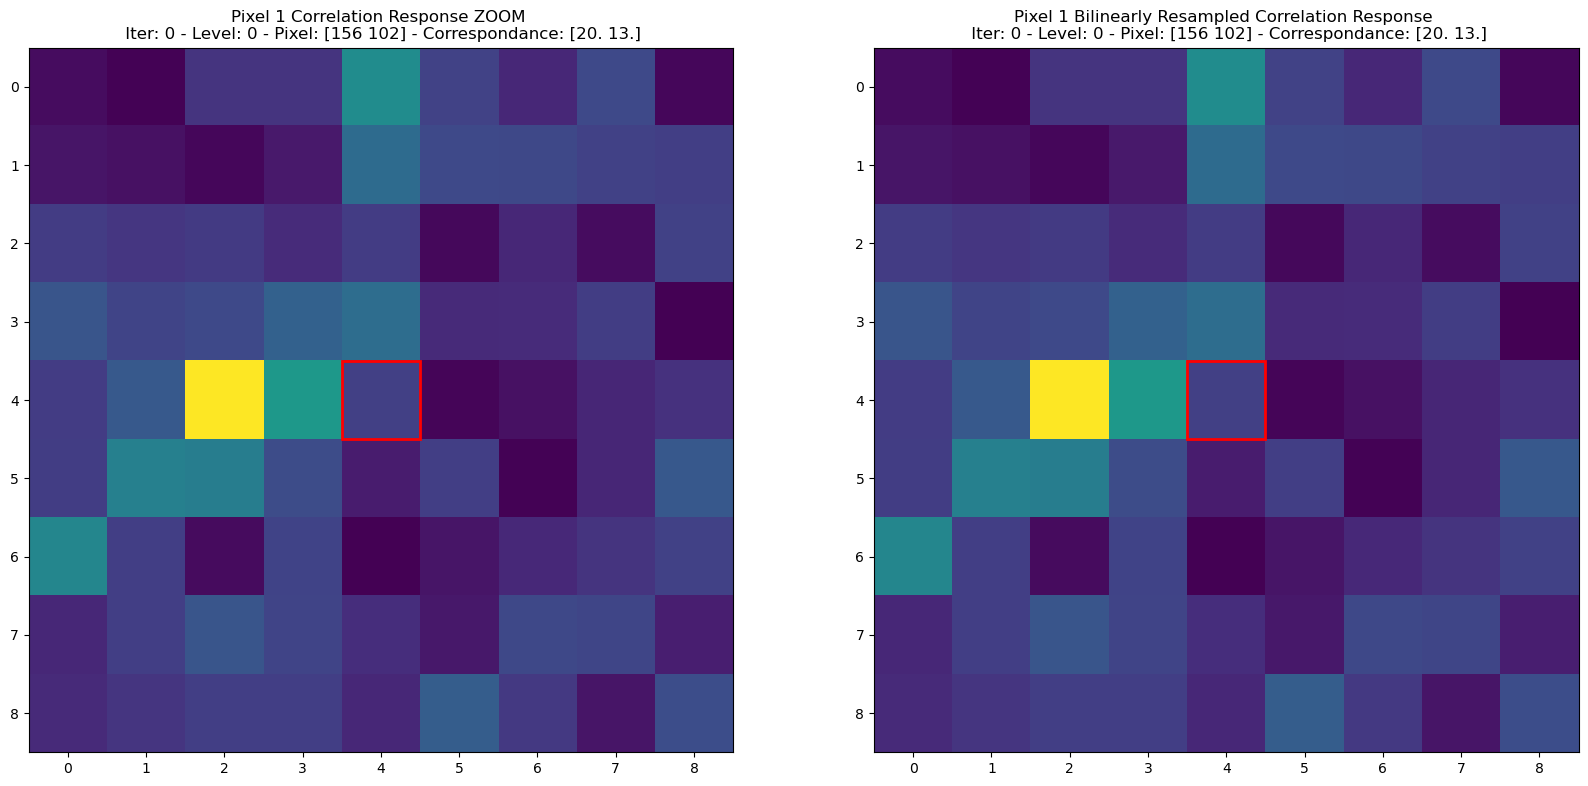

In [109]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(zoomed_response);
ax[0].set_title(f"Pixel {pix} Correlation Response ZOOM \n "
             + f"Iter: {itr} - Level: {lvl} - Pixel: {test_pixel[1:]} - Correspondance: {pixel_loc.round(2)[::-1]}");
# mark I2 pixel under test
rect = patches.Rectangle((r + (pixel_loc % 1) - 0.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)


ax[1].imshow(bilres_response);
ax[1].set_title(f"Pixel {pix} Bilinearly Resampled Correlation Response \n "
             + f"Iter: {itr} - Level: {lvl} - Pixel: {test_pixel[1:]} - Correspondance: {pixel_loc.round(2)[::-1]}");

# mark I2 pixel under test
rect = patches.Rectangle((3.5, 3.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)

At iteration 1, the bilinear resampling should be the same since there is no optical flow. (Unless we warm start with previous flow)

## **Inspect the Motion Features**

In [37]:
motion_features[itr].shape

torch.Size([1, 128, 55, 128])

In [110]:
m_feats = motion_features[itr].squeeze(0).cpu().numpy()

In [114]:
for i in range(20):
    m_feats = motion_features[i].squeeze(0).cpu().numpy()

    fig, ax = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle(f"Motion Features - Iter: {i}", size=18, weight=10);
    ax[0][0].imshow(m_feats[11, :, :])
    ax[0][0].set_title("Motion Feature: 11")

    ax[0][1].imshow(m_feats[68, :, :])
    ax[0][1].set_title("Motion Feature: 68")

    ax[1][0].imshow(m_feats[98, :, :])
    ax[1][0].set_title("Motion Feature: 98")

    ax[1][1].imshow(m_feats[100, :, :])
    ax[1][1].set_title("Motion Feature: 100");

    fig.savefig(f"C:\\Users\\itber\\Documents\\utils\\gif_maker\\frames_4\\motion_feats_iter_0000{i}");
    plt.close();

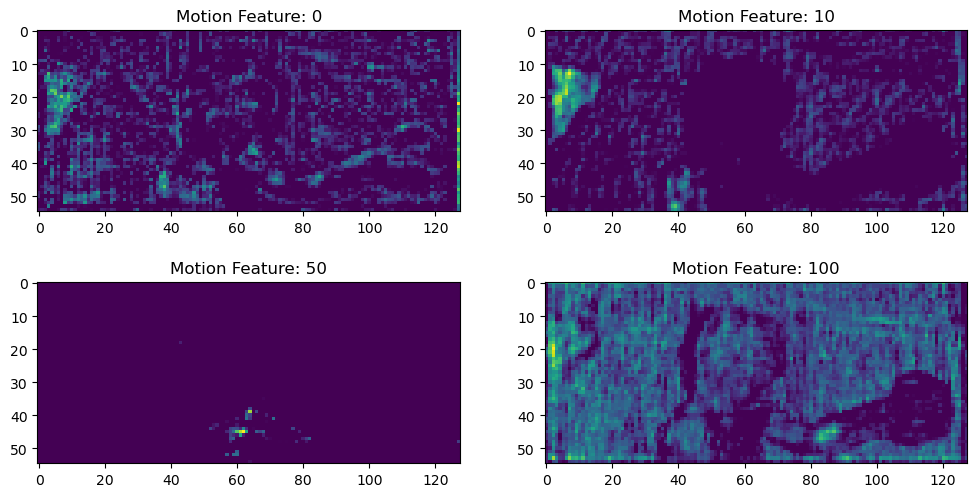

In [112]:
m_feats = motion_features[0].squeeze(0).cpu().numpy()

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].imshow(m_feats[11, :, :])
ax[0][0].set_title("Motion Feature: 0")

ax[0][1].imshow(m_feats[10, :, :])
ax[0][1].set_title("Motion Feature: 10")

ax[1][0].imshow(m_feats[50, :, :])
ax[1][0].set_title("Motion Feature: 50")

ax[1][1].imshow(m_feats[100, :, :])
ax[1][1].set_title("Motion Feature: 100");

## **Inspect the hidden states**

In [24]:
hidden_states[0].shape

torch.Size([1, 128, 55, 128])

In [26]:
hid_states = hidden_states[0].squeeze(0).cpu().numpy()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].imshow(hid_states[0, :, :])
ax[0][0].set_title("Hidden State: 0")

ax[0][1].imshow(hid_states[10, :, :])
ax[0][1].set_title("Hidden State: 10")

ax[1][0].imshow(hid_states[50, :, :])
ax[1][0].set_title("Hidden State: 50")

ax[1][1].imshow(hid_states[100, :, :])
ax[1][1].set_title("Hidden State: 100");

In [36]:
for i in range(20):

    # plt.figure(figsize=(8, 4))
    # plt.imshow(hid_states[i, :, :])
    # plt.title(f"Hidden State: {i}")

    h_states = hidden_states[i].squeeze(0).cpu().numpy()

    fig, ax = plt.subplots(2, 2, figsize=(12, 6))
    ax[0][0].imshow(h_states[0, :, :])
    ax[0][0].set_title(f"Hidden State: 0 - iter: {i}")

    ax[0][1].imshow(h_states[10, :, :])
    ax[0][1].set_title(f"Hidden State: 10 - iter: {i}")

    ax[1][0].imshow(h_states[50, :, :])
    ax[1][0].set_title(f"Hidden State: 50 - iter: {i}")

    ax[1][1].imshow(h_states[100, :, :])
    ax[1][1].set_title(f"Hidden State: 100 - iter: {i}");

    fig.savefig(f"C:\\Users\\itber\\Documents\\utils\\gif_maker\\frames_6\\hidden_state_{i}");
    plt.close();

Text(0.5, 1.0, 'Hidden State: 19')

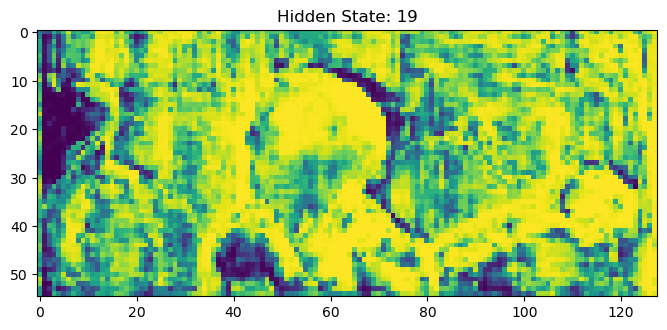

In [34]:
plt.figure(figsize=(8, 4))
plt.imshow(hid_states[i, :, :])
plt.title(f"Hidden State: {i}")